In [4]:
import git
from pathlib import Path
import os
from matplotlib import colors

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
np.random.seed(0)

In [5]:
SAVE_FIGS = True
plots_path = os.path.join(ROOT_DIR, "publication", "poster", "plots")

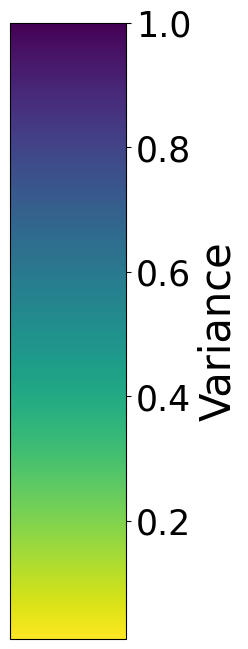

In [6]:
from matplotlib.colors import ListedColormap, LogNorm, Normalize
import numpy as np
import matplotlib.pyplot as plt

# Set the split ratio (e.g., 0.25 means 25% viridis_r, 75% magma_r)
split_ratio = 1
n_total = 256
n1 = int(n_total * split_ratio)
n2 = n_total - n1

# Get color arrays from the colormaps
viridis_r = plt.get_cmap('viridis_r')(np.linspace(0, 1, n1))
magma_r = plt.get_cmap('magma_r')(np.linspace(0.75, 1, n2))

# Concatenate the color arrays
combined_colors = np.vstack([viridis_r, magma_r])
custom_cmap = ListedColormap(combined_colors)
def color_fn(variance):
        return custom_cmap(norm(variance))

# Create a colorbar for demonstration
min_value = 1e-2
max_value = 1
fig, ax = plt.subplots(figsize=(1.5, 8))
norm = Normalize(vmin=min_value, vmax=max_value)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax)
cb.ax.tick_params(labelsize=25)
cb.set_label('Variance', fontsize=30)
plt.ylim((min_value, max_value))
plt.show()
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"varianceColorBar.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

In [7]:
def plot_pdf_components(r, eta, scale, components = 10, mode = "equal", color_fn = None, custom_var = None, varlim = None, xlim = None, lin_lim = None, log_lim = None, debug = True, prior_pdf = None, title = None, edgecolor = 'black'):
    fontsize=20
    
    beta = (eta + 1.5) / r
    
    if mode == "equal":
        x = np.linspace(0, 1, components+2)[1:-1][::-1]  # Exclude 0 and 1 to avoid singularities
        vars = stats.gengamma(a=beta, c=r, scale=scale).ppf(x)
        weights = np.ones(components) / components
    elif mode == "variance":
        if custom_var is None and varlim is None:
            raise ValueError("Either custom_var or varlim must be provided for 'variance' mode.")
        if custom_var is not None:
            vars = np.array(custom_var)
        elif varlim is not None:
            if varlim[2] == "linear":
                vars = np.linspace(varlim[0], varlim[1], components)[::-1]
            elif varlim[2] == "log":
                vars = np.logspace(np.log10(varlim[0]), np.log10(varlim[1]), components)[::-1]
        weights = stats.gengamma(a = beta, c = r, scale=scale).cdf(vars[::-1])
        weights = np.diff(weights, prepend=0)[::-1]
        print(sum(weights))  # Convert cumulative weights to densities
        print(weights)
    
    
    if prior_pdf is None:
        xs, genGamma_prior = compute_prior_pdf(r=r, eta=eta, scale=scale, n_samples=2000, debug=debug)
    else:
        xs = np.linspace(-5, 5, 1000)
        genGamma_prior = prior_pdf

    means = np.zeros(components)
    print(vars)
    norm_pdfs = np.array([stats.norm.pdf(xs, loc=mean, scale=np.sqrt(var)) for mean, var in zip(means, vars)])
    if color_fn is None:
        cmap = plt.cm.viridis(np.linspace(0, 1, components))
    else:
        cmap = [color_fn(var) for var in vars]  # Create a colormap based on the variances

    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True, constrained_layout=True)

    for ax, yscale in zip(axs, ['linear', 'log']):
    # Plot stackplot
        ax.stackplot(
            xs,
            *(norm_pdfs * weights[:, None]),
            colors=cmap,
            labels=[f'Component {i+1} (var={vars[i]:.2f}), (wt={weights[i]:.2f})' for i in range(components)]
        )
        # Overlay the GenGamma prior
        ax.plot(xs, genGamma_prior(xs), label='GenGamma Prior', color='black', linestyle='--', linewidth=2)

        # Set styles
        for polygon in ax.collections:
            polygon.set_edgecolor(edgecolor)
        ax.set_xlabel(r'$x$', fontsize=fontsize)
        
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        ax.set_yscale(yscale)

    axs[0].set_ylabel(r'$\pi (x)$', fontsize=fontsize)
    axs[1].set_ylabel('', fontsize=fontsize)

    # Shared title and colorbar
    if xlim is not None:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)
    if lin_lim is not None:
        axs[0].set_ylim(lin_lim)
    if log_lim is not None:
        axs[1].set_ylim(log_lim)

    if title is None:
        title = f'Scale Mixture of Normals with GenGamma Prior\nr={r}, eta={eta}, scale={scale}, components={components}'
    fig.suptitle(title, fontsize=fontsize+4)

    # Only show legend for the first axis, outside the plot
    handles, labels = axs[0].get_legend_handles_labels()
    # Remove duplicate labels (e.g., GenGamma Prior)
    unique = dict(zip(labels, handles))
    #fig.legend(unique.values(), unique.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, borderaxespad=0.)
    return fig

Params: 1, -1
Chebyshev bound: 22.360679774997898
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.04603906744925168


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.0009957434972748258
First CDF value: 1.2854592126570933e-15
Last CDF value: 0.9999999999999987
Tail bound: 0.001
KstestResult(statistic=0.009975869994571146, pvalue=0.27080239423547314, statistic_location=-0.4318297273111267, statistic_sign=-1)
[1.42910075 0.89134979 0.60148903 0.41264785 0.27964624 0.18276172
 0.11176478 0.06081527 0.02642335 0.00651914]


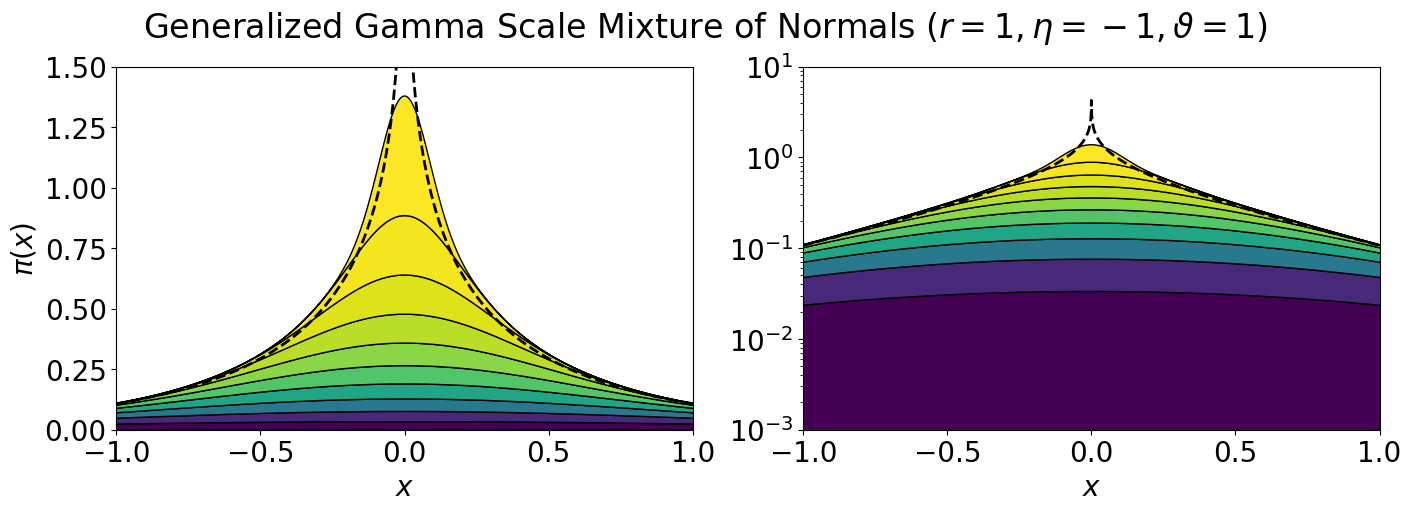

In [8]:
title = f'Generalized Gamma Scale Mixture of Normals ' + r'($r=1, \eta=-1, \vartheta=1$)'
fig = plot_pdf_components(r=1, eta=-1, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-1, 1),  lin_lim= [0, 1.5], log_lim=(1e-3, 10), title = title,  debug=True)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_r=1_eta=1_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 1, -1
Chebyshev bound: 22.360679774997898
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.04603906744925168


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.0009957434972748258
First CDF value: 1.2854592126570933e-15
Last CDF value: 0.9999999999999987
Tail bound: 0.001
KstestResult(statistic=0.009132865930983058, pvalue=0.37242324837549934, statistic_location=-0.2391082913174209, statistic_sign=1)
[6.43687770e+00 5.79028581e+00 5.41409162e+00 ... 7.84875237e-07
 3.48833337e-07 8.72083191e-08]


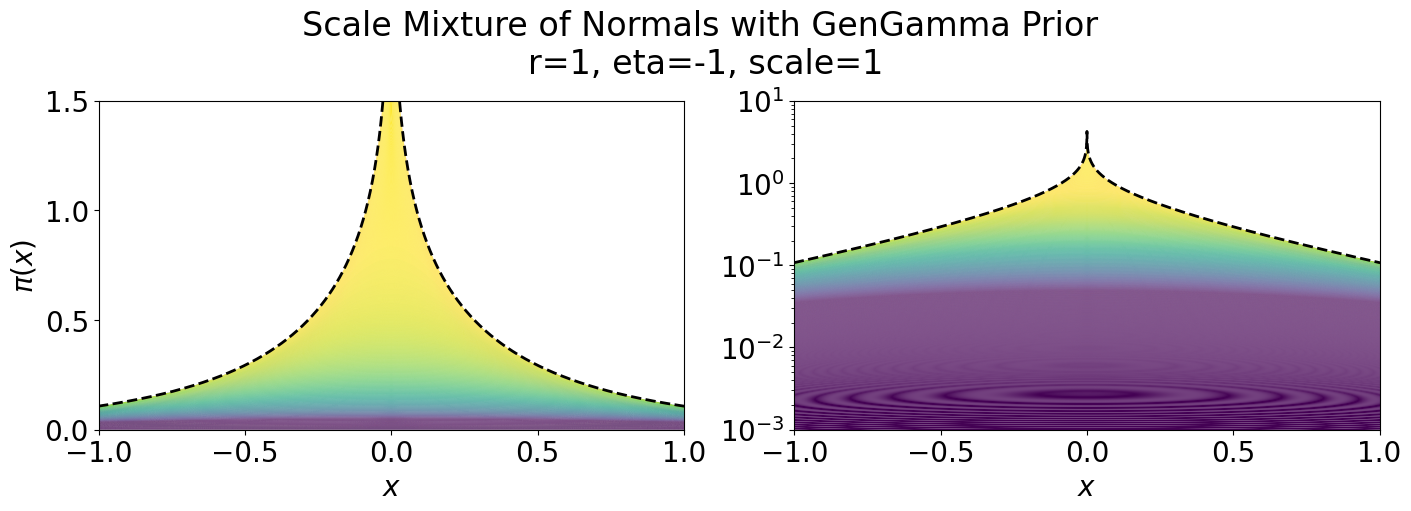

In [9]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=1, eta=-1, scale=1'
fig = plot_pdf_components(r=1, eta=-1, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-1, 1),  lin_lim= [0, 1.5], log_lim=(1e-3, 10), title = title, debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=1_eta=1_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')